In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
from tensorflow import keras
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sklearn
import os
import glob
from scipy import stats
import math
import pandas as pd
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from stellargraph.layer import GCN_LSTM
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
#load data 
df_list = []
path = r'F:\OneDrive - Nanyang Technological University\PhD Study\P10_TBM positional optimization\Original data'
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
TBMParameters = pd.DataFrame(frame, columns =['[19]Thrust Force','[20]Penetration',
                                           '[25]CHD Torque','[26]CHD RPM','[68]Earth Pressure(LM)','[71]Earth Pressure(RM)',
                                           '[262]Thrust Cylinders Right (Group A)','[263]Thrust Cylinders Down(Group B)',
                                           '[264]Thrust Cylinders Left (Group C)','[265]Thrust Cylinders Top(Group D)',
                                           '[21]Articulation Displacement A','[22]Articulation Displacement B',
                                           '[23]Articulation Displacement C','[24]Articulation Displacement D',
                                              '[85]H Deviation (Art)','[86]H Deviation (Tail)',
                                           '[88]V Deviation (Art)','[89]V Deviation (Tail)'])
                                             
TBMParameters = TBMParameters.apply(pd.to_numeric, errors='coerce')
#Remove nan
TBMParameters = TBMParameters.dropna()
TBMParameters = TBMParameters.loc[(TBMParameters!=0).all(1)]
TBMParameters = TBMParameters[(np.abs(stats.zscore(TBMParameters)) < 3).all(axis=1)]

In [5]:
values = TBMParameters.values
values=values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
num_of_data_series = 2
num_of_t_for_prediction = 1
reframe = series_to_supervised(scaled, num_of_data_series, num_of_t_for_prediction)
reframe.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t)
2,0.551199,0.600000,0.193869,0.517857,0.271429,0.157895,0.317514,0.262946,0.657534,0.304965,...,0.712603,0.297499,0.15,0.636364,0.636364,0.434783,0.511840,0.323604,0.495951,0.640000
3,0.548590,0.600000,0.272577,0.500000,0.235714,0.127820,0.333051,0.254241,0.683014,0.293393,...,0.718082,0.296379,0.15,0.636364,0.636364,0.434783,0.520947,0.346447,0.497976,0.640000
4,0.549170,0.600000,0.318144,0.500000,0.200000,0.120301,0.316949,0.214509,0.712603,0.297499,...,0.604931,0.286674,0.15,0.636364,0.636364,0.434783,0.517304,0.355330,0.497976,0.641739
5,0.507501,0.622222,0.346313,0.500000,0.092857,0.045113,0.285311,0.153571,0.718082,0.296379,...,0.651781,0.306831,0.15,0.590909,0.636364,0.434783,0.519126,0.369289,0.495951,0.640000
6,0.510544,0.600000,0.324772,0.500000,0.142857,0.097744,0.346045,0.230580,0.604931,0.286674,...,0.643836,0.292273,0.15,0.590909,0.636364,0.434783,0.519126,0.361675,0.495951,0.640000


In [6]:
#Do HDA

#Split data for training and testing
reframed=reframe.values
train = reframed[:int(reframed.shape[0]*0.8), :]
test = reframed[int(reframed.shape[0]*0.8):, :]
train_X, train_y = train[:,:-4], train[:,-4]
test_X, test_y = test[:,:-4], test[:,-4]
 
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test_y,test[:,-3:]), axis=1)
inv_y_train = inv_y_train[:,-18:]
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -4]

#save the result
actual_HDA = inv_y


In [7]:
#Do HDT

#Split data for training and testing
reframed=reframe.values
train = reframed[:int(reframed.shape[0]*0.8), :]
test = reframed[int(reframed.shape[0]*0.8):, :]
train_X, train_y = train[:,:-4], train[:,-3]
test_X, test_y = test[:,:-4], test[:,-3]
 
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test[:,-3:-2],test_y,test[:,-2:]), axis=1)
inv_y_train = inv_y_train[:,-18:]
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -3]

#save the result
actual_HDT = inv_y


In [8]:
#Do VDA

#Split data for training and testing
reframed=reframe.values
train = reframed[:int(reframed.shape[0]*0.8), :]
test = reframed[int(reframed.shape[0]*0.8):, :]
train_X, train_y = train[:,:-4], train[:,-2]
test_X, test_y = test[:,:-4], test[:,-2]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test[:,-3:-1],test_y,test[:,-1:]), axis=1)
inv_y_train = inv_y_train[:,-18:]
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -2]

#save the result
actual_VDA = inv_y


In [9]:
#Do VDT

#Split data for training and testing
reframed=reframe.values
train = reframed[:int(reframed.shape[0]*0.8), :]
test = reframed[int(reframed.shape[0]*0.8):, :]
train_X, train_y = train[:,:-4], train[:,-1]
test_X, test_y = test[:,:-4], test[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test[:,-3:],test_y), axis=1)
inv_y_train = inv_y_train[:,-18:]
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]

#save the result
actual_VDT = inv_y


In [10]:
#Preparation for optimization
import geatpy as ea
from scipy.spatial import distance

model_HDA_ = keras.models.load_model("model_HDA")
model_HDT_ = keras.models.load_model("model_HDT")
model_VDA_ = keras.models.load_model("model_VDA")
model_VDT_ = keras.models.load_model("model_VDT")

#define the objective function

def object_1(X):
    y_predict = model_HDA_.predict(X)
    y_predict = y_predict[:,0].reshape(len(y_predict[:,0]),1)
    inv_y_test = np.concatenate((test[-population:,:-4],y_predict,test[-population:,-3:]), axis=1)
    inv_y_test = inv_y_test[:,-18:]
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_predict=inv_y_test[:,-4]
    return inv_y_predict

def object_2(X):
    y_predict = model_HDT_.predict(X)
    y_predict = y_predict[:,0].reshape(len(y_predict[:,0]),1)
    inv_y_test = np.concatenate((test[-population:,:-3],y_predict,test[-population:,-2:]), axis=1)
    inv_y_test = inv_y_test[:,-18:]
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_predict=inv_y_test[:,-3]
    return inv_y_predict

def object_3(X):
    y_predict = model_VDA_.predict(X)
    y_predict = y_predict[:,0].reshape(len(y_predict[:,0]),1)
    inv_y_test = np.concatenate((test[-population:,:-2],y_predict,test[-population:,-1:]), axis=1)
    inv_y_test = inv_y_test[:,-18:]
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_predict=inv_y_test[:,-2]
    return inv_y_predict

def object_4(X):
    y_predict = model_VDT_.predict(X)
    y_predict = y_predict[:,0].reshape(len(y_predict[:,0]),1)
    inv_y_test = np.concatenate((test[-population:,:-1],y_predict), axis=1)
    inv_y_test = inv_y_test[:,-18:]
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_predict=inv_y_test[:,-1]
    return inv_y_predict

In [8]:
#deviates by 30 percent
data_num = 200
population = 100

reframed=reframe.values
train = reframed[:int(reframed.shape[0]*0.8), :]
test = reframed[int(reframed.shape[0]*0.8):, :]
X = test[:data_num,:-4]
y = test[:data_num,-4:]
   
xl0=X[:,0]
xl1=X[:,1]
xl2=X[:,2]
xl3=X[:,3]
xl4=X[:,4]
xl5=X[:,5]
xl6=X[:,6]
xl7=X[:,7]
xl8=X[:,8]
xl9=X[:,9]
xl10=X[:,10]
xl11=X[:,11]
xl12=X[:,12]
xl13=X[:,13]
xl14=X[:,14]
xl15=X[:,15]
xl16=X[:,16]
xl17=X[:,17]
xl18=X[:,18]
xl19=X[:,19]
xl20=X[:,20]
xl21=X[:,21]
xl22=X[:,22]
xl23=X[:,23]
xl24=X[:,24]
xl25=X[:,25]
xl26=X[:,26]
xl27=X[:,27]
xl28=X[:,28]
xl29=X[:,29]
xl30=X[:,30]
xl31=X[:,31]
xl32=X[:,32]
xl33=X[:,33]
xl34=X[:,34]
xl35=X[:,35]
xl36=X[:,36]
xl37=X[:,37]
xl38=X[:,38]
xl39=X[:,39]
xl40=X[:,40]
xl41=X[:,41]
xl42=X[:,42]
xl43=X[:,43]
xl44=X[:,44]
xl45=X[:,45]
xl46=X[:,46]
xl47=X[:,47]
xl48=X[:,48]
xl49=X[:,49]

accu_f = []
accu_X = []

for i in range (len(X)):
    print(i)
    class MyProblem(ea.Problem):  

        def __init__(self, M=4):
            name = 'MyProblem'  
            Dim = 50  
            maxormins = [1,1,1,1]  
            varTypes = [0] * Dim  
            lb = [xl0[i],xl1[i],xl2[i],xl3[i],xl4[i],xl5[i],xl6[i],
               xl7[i]*0.7,xl8[i]*0.7,xl9[i]*0.7,xl10[i]*0.7,xl11[i]*0.7,xl12[i]*0.7,xl13[i]*0.7,
               xl14[i],xl15[i],xl16[i],xl17[i],xl18[i],xl19[i],xl20[i],
               xl21[i],xl22[i],xl23[i],xl24[i]*0.7,xl25[i]*0.7,xl26[i]*0.7,xl27[i]*0.7,
               xl28[i]*0.7,xl29[i]*0.7,xl30[i]*0.7,xl31[i]*0.7,xl32[i],xl33[i],xl34[i],
               xl35[i],xl36[i],xl37[i],xl38[i],xl39[i],xl40[i],xl41[i],
               xl42[i]*0.7,xl43[i]*0.7,xl44[i]*0.7,xl45[i]*0.7,xl46[i]*0.7,xl47[i]*0.7,xl48[i]*0.7,xl49[i]*0.7]
            ub = [xl0[i]+0.001,xl1[i]+0.001,xl2[i]+0.001,xl3[i]+0.001,xl4[i]+0.001,xl5[i]+0.001,xl6[i]+0.001,
               xl7[i]*1.3,xl8[i]*1.3,xl9[i]*1.3,xl10[i]*1.3,xl11[i]*1.3,xl12[i]*1.3,xl13[i]*1.3,
               xl14[i]+0.001,xl15[i]+0.001,xl16[i]+0.001,xl17[i]+0.001,xl18[i]+0.001,xl19[i]+0.001,xl20[i]+0.001,
               xl21[i]+0.001,xl22[i]+0.001,xl23[i]+0.001,xl24[i]*1.3,xl25[i]*1.3,xl26[i]*1.3,xl27[i]*1.3,
               xl28[i]*1.3,xl29[i]*1.3,xl30[i]*1.3,xl31[i]*1.3,xl32[i]+0.001,xl33[i]+0.001,xl34[i]+0.001,
               xl35[i]+0.001,xl36[i]+0.001,xl37[i]+0.001,xl38[i]+0.001,xl39[i]+0.001,xl40[i]+0.001,xl41[i]+0.001,
               xl42[i]*1.3,xl43[i]*1.3,xl44[i]*1.3,xl45[i]*1.3,xl46[i]*1.3,xl47[i]*1.3,xl48[i]*1.3,xl49[i]*1.3]  
            lbin = [1] * Dim  
            ubin = [1] * Dim  
            
            ea.Problem.__init__(self,
                            name,
                            M,
                            maxormins,
                            Dim,
                            varTypes,
                            lb,
                            ub,
                            lbin,
                            ubin)

        def evalVars(self, Var):  
            f1 = abs(object_1(Var))
            f2 = abs(object_2(Var))
            f3 = abs(object_3(Var))
            f4 = abs(object_4(Var))

            ObjV = np.column_stack([f1, f2, f3, f4])
            return ObjV

    problem = MyProblem()
    
    algorithm = ea.moea_NSGA2_templet(
        problem,
        ea.Population(Encoding='RI', NIND=population),
        MAXGEN=50,  
        logTras=0)  
    algorithm.mutOper.Pm = 0.5  
    algorithm.recOper.XOVR = 0.2  
        
    res = ea.optimize(algorithm,
                    verbose=False,
                    drawing=0,
                    outputMsg=False,
                    drawLog=False,
                    saveFlag=False)
    
    #Technique for Order Preference by Similarity to Ideal Solution (TOPSIS)
    #1.Positivization
    F = res['ObjV']
    input_X = res['Vars']
    x1_=F[:,0]
    x2_=F[:,1]
    x3_=F[:,2]
    x4_=F[:,3]

    x = np.concatenate((x1_.reshape(len(F),1), x2_.reshape(len(F),1), x3_.reshape(len(F),1), x4_.reshape(len(F),1)), axis=1)

    #2.Find the ideal solution
    x1_ideal=min(x1_)
    x2_ideal=min(x2_)
    x3_ideal=min(x3_)
    x4_ideal=min(x4_)
    x_ideal=[x1_ideal,x2_ideal,x3_ideal,x4_ideal]

    x1_neg=max(x1_)
    x2_neg=max(x2_)
    x3_neg=max(x3_)
    x4_neg=max(x4_)
    x_neg=[x1_neg, x2_neg, x3_neg, x4_neg]

    #3.Calculate distance to the ideal and neg
    z_pos=[]
    z_neg=[]
    S=[]

    for j in range(len(x1_)):
        z1 = distance.euclidean(x[j,:], x_ideal)+0.1
        z2 = distance.euclidean(x[j,:], x_neg)+0.1
        z_pos = np.append(z_pos, z1)
        z_neg = np.append(z_neg, z2)
        s = z2/(z1+z2)
        S = np.append(S,s)
    
    #4.Find the ideal solution
    index_s=np.argmax(S)
    accu_X = np.append(accu_X, input_X[index_s])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


-25.199 -25.2385 -12.639 -40.8115
-23.684277 -21.435022 -12.086062 -40.107994
0.059015608648769556 0.1441110777724498 0.04208843748579966 0.01872547833639828 0.06265995455964003


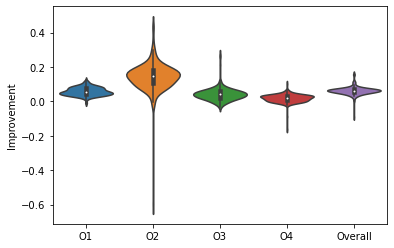

In [12]:
import seaborn as sns
#result output

#accu_X1 = accu_X.reshape(int(len(accu_X)/50),50)  <-- This is the actual step that follows the script above
#accu_X1_30pc = accu_X1
#np.savetxt('X_30percent_woup.csv', accu_X1, delimiter = ",")
accu_X1 = pd.read_csv('X_30percent_woup.csv', header=None)

#calculate optimized values
y_predict1 = model_HDA_.predict(accu_X1)
y_predict1 = y_predict1[:,0].reshape(len(y_predict1[:,0]),1)
y_predict2 = model_HDT_.predict(accu_X1)
y_predict2 = y_predict2[:,0].reshape(len(y_predict2[:,0]),1)
y_predict3 = model_VDA_.predict(accu_X1)
y_predict3 = y_predict3[:,0].reshape(len(y_predict3[:,0]),1)
y_predict4 = model_VDT_.predict(accu_X1)
y_predict4 = y_predict4[:,0].reshape(len(y_predict4[:,0]),1)

inv_y_test = np.concatenate((test[-len(accu_X1):,:-4],y_predict1,y_predict2,y_predict3,y_predict4), axis=1)
inv_y_test = inv_y_test[:,-18:]
inv_y_test = scaler.inverse_transform(inv_y_test)
y1_opt=inv_y_test[:,-4]
y2_opt=inv_y_test[:,-3]
y3_opt=inv_y_test[:,-2]
y4_opt=inv_y_test[:,-1]
    
#Original values
y1 = actual_HDA[:len(accu_X1)]
y2 = actual_HDT[:len(accu_X1)]
y3 = actual_VDA[:len(accu_X1)]
y4 = actual_VDT[:len(accu_X1)]

#improvement
y1_imp_=[]
y2_imp_=[]
y3_imp_=[]
y4_imp_=[]
overall_imp_30pc=[]

for i in range(len(y1_opt)):
    y1_imp = (abs(y1[i])-abs(y1_opt[i]))/abs(y1[i])
    y2_imp = (abs(y2[i])-abs(y2_opt[i]))/abs(y2[i])
    y3_imp = (abs(y3[i])-abs(y3_opt[i]))/abs(y3[i])
    y4_imp = (abs(y4[i])-abs(y4_opt[i]))/abs(y4[i])
    overall_imp = (abs(y1[i])+abs(y2[i])+abs(y3[i])+abs(y4[i])-(abs(y1_opt[i])+abs(y2_opt[i])+abs(y3_opt[i])+abs(y4_opt[i])))/(abs(y1[i])+abs(y2[i])+abs(y3[i])+abs(y4[i]))
    y1_imp_ = np.append(y1_imp_, y1_imp)
    y2_imp_ = np.append(y2_imp_, y2_imp)
    y3_imp_ = np.append(y3_imp_, y3_imp)
    y4_imp_ = np.append(y4_imp_, y4_imp)
    overall_imp_30pc = np.append(overall_imp_30pc, overall_imp)

print(np.mean(y1),np.mean(y2),np.mean(y3), np.mean(y4))
print(np.mean(y1_opt),np.mean(y2_opt),np.mean(y3_opt),np.mean(y4_opt))
print(np.mean(y1_imp_),np.mean(y2_imp_),np.mean(y3_imp_),np.mean(y4_imp_), np.mean(overall_imp_30pc))

imp = np.concatenate((y1_imp_,y2_imp_,y3_imp_,y4_imp_,overall_imp_30pc), axis=0)

#for plot
a= np.repeat('O1',len(y1))
b= np.repeat('O2',len(y1))
c= np.repeat('O3',len(y1))
d= np.repeat('O4',len(y1))
e= np.repeat('Overall',len(y1))
group = np.concatenate((a,b,c,d,e),axis=0)

sns.violinplot(x=group, y=imp, scale = 'width')
plt.ylabel('Improvement')
plt.show()
#plt.savefig('improvement_30percent_woup.svg')

In [13]:
accu_X1 = pd.read_csv('X_30percent.csv', header=None)
y_predict1 = model_HDA_.predict(accu_X1)
y_predict1 = y_predict1[:,0].reshape(len(y_predict1[:,0]),1)
y_predict2 = model_HDT_.predict(accu_X1)
y_predict2 = y_predict2[:,0].reshape(len(y_predict2[:,0]),1)
y_predict3 = model_VDA_.predict(accu_X1)
y_predict3 = y_predict3[:,0].reshape(len(y_predict3[:,0]),1)
y_predict4 = model_VDT_.predict(accu_X1)
y_predict4 = y_predict4[:,0].reshape(len(y_predict4[:,0]),1)

inv_y_test = np.concatenate((test[-len(accu_X1):,:-4],y_predict1,y_predict2,y_predict3,y_predict4), axis=1)
inv_y_test = inv_y_test[:,-18:]
inv_y_test = scaler.inverse_transform(inv_y_test)
y1_opt_ol=inv_y_test[:,-4]
y2_opt_ol=inv_y_test[:,-3]
y3_opt_ol=inv_y_test[:,-2]
y4_opt_ol=inv_y_test[:,-1]

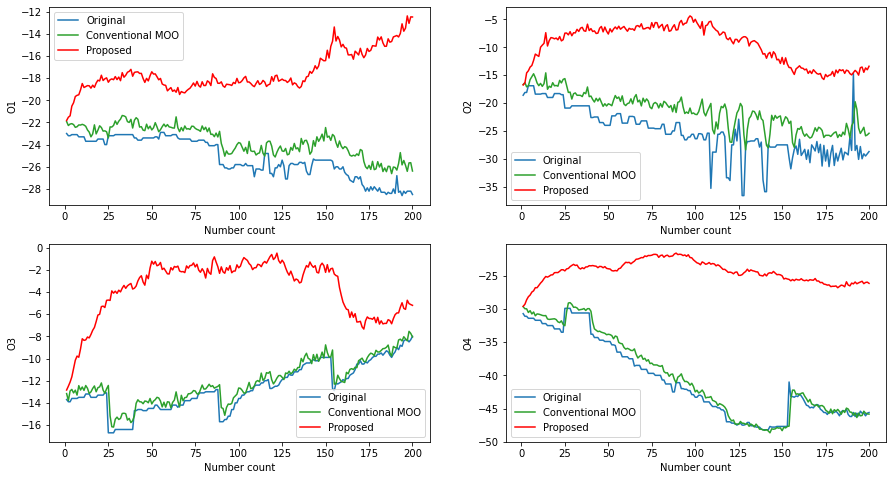

In [20]:
#plot results for improvement validation
X = y1_opt_ol
plt.figure(figsize=(15,8))
plt.subplot(221)
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y1, color = "tab:blue", label='Original')
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y1_opt.flatten(), color = "tab:green", label='Conventional MOO')
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y1_opt_ol.flatten(), color = "red", label='Proposed')
plt.xlabel('Number count')
plt.ylabel('O1')
plt.subplot(222)
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y2, color = "tab:blue", label='Original')
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y2_opt.flatten(), color = "tab:green", label='Conventional MOO')
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y2_opt_ol.flatten(), color = "red", label='Proposed')
plt.xlabel('Number count')
plt.ylabel('O2')
plt.subplot(223)
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y3, color = "tab:blue", label='Original')
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y3_opt.flatten(), color = "tab:green", label='Conventional MOO')
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y3_opt_ol.flatten(), color = "red", label='Proposed')
plt.xlabel('Number count')
plt.ylabel('O3')
plt.subplot(224)
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y4, color = "tab:blue", label='Original')
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y4_opt.flatten(), color = "tab:green", label='Conventional MOO')
sns.lineplot(x=np.linspace(1,len(X),len(X)), y=y4_opt_ol.flatten(), color = "red", label='Proposed')
plt.xlabel('Number count')
plt.ylabel('O4')
#plt.show()
plt.savefig("Comparison between online and normal MOO.svg")